In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

RSEED = 42

In [2]:
from sklearn.pipeline import Pipeline # focus on this one
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, mean_squared_error, r2_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [3]:
df = pd.read_pickle('data_strube/pickles/df_merge_weatherloc_dev_stage.pkl')
df

,betaine_nir,cry_nir,csy_nir,dm_nir,fieldid,region,invert_nir,mark_nir,ms_comp,obj,...,wind_direction_devstage_3,wind_speed_avg_devstage_1,wind_speed_avg_devstage_2,wind_speed_avg_devstage_3,wind_speed_gusts_devstage_1,wind_speed_gusts_devstage_2,wind_speed_gusts_devstage_3,wind_speed_max_devstage_1,wind_speed_max_devstage_2,wind_speed_max_devstage_3
0,0.1551,54.60,8.838976,21.5439,Emmeloord,Niederlande,0.1769,5.3553,2,23,...,162.221843,2.899709,1.797241,1.100000,5.343605,3.870664,2.951536,3.606541,2.293074,1.495336
1,0.1502,51.07,8.493911,21.8552,Emmeloord,Niederlande,0.1539,5.2233,6,3,...,162.221843,2.899709,1.797241,1.100000,5.343605,3.870664,2.951536,3.606541,2.293074,1.495336
2,0.1370,52.73,8.356650,21.1878,Emmeloord,Niederlande,0.1643,5.3398,2,28,...,162.221843,2.899709,1.797241,1.100000,5.343605,3.870664,2.951536,3.606541,2.293074,1.495336
3,0.1391,44.33,6.957815,21.1140,Emmeloord,Niederlande,0.1647,5.4185,1,33,...,162.221843,2.899709,1.797241,1.100000,5.343605,3.870664,2.951536,3.606541,2.293074,1.495336
4,0.1286,50.00,7.835800,20.8531,Emmeloord,Niederlande,0.1615,5.1815,2,7,...,162.221843,2.899709,1.797241,1.100000,5.343605,3.870664,2.951536,3.606541,2.293074,1.495336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,0.1108,67.87,11.721760,22.7418,Anklam,Norddeutschland,0.0410,5.4709,2,13,...,196.921844,2.932386,1.555776,1.903607,5.117756,3.252698,3.642184,3.567330,2.009434,2.362525
9650,0.0818,74.47,12.498747,21.7245,Anklam,Norddeutschland,0.0677,4.9409,2,17,...,196.921844,2.932386,1.555776,1.903607,5.117756,3.252698,3.642184,3.567330,2.009434,2.362525
9651,0.0783,70.93,12.182795,22.1038,Anklam,Norddeutschland,0.0647,4.9280,2,18,...,196.921844,2.932386,1.555776,1.903607,5.117756,3.252698,3.642184,3.567330,2.009434,2.362525
9652,0.0899,71.13,12.296172,22.2158,Anklam,Norddeutschland,0.0835,4.9289,2,8,...,196.921844,2.932386,1.555776,1.903607,5.117756,3.252698,3.642184,3.567330,2.009434,2.362525


In [4]:
df.shape

(8768, 178)

In [5]:
# Dropping the unnecessary columns 
df.drop(['betaine_nir', 'cry_nir', 'dm_nir', 'invert_nir', 'mark_nir', 'csy_nir', 'totaln_nir','fieldid', 'region', 'station_location', 'ms_comp', 'obj', 'otype_comp', 'pollinator_comp', 'seriesid', 'x', 'y'
         ], axis=1, inplace=True)
df.columns
df.columns

Index(['sc_nir', 'seednames_coded', 'air_temperature_avg_devstage_1',
       'air_temperature_avg_devstage_2', 'air_temperature_avg_devstage_3',
       'air_temperature_max_devstage_1', 'air_temperature_max_devstage_2',
       'air_temperature_max_devstage_3', 'air_temperature_min_devstage_1',
       'air_temperature_min_devstage_2',
       ...
       'wind_direction_devstage_3', 'wind_speed_avg_devstage_1',
       'wind_speed_avg_devstage_2', 'wind_speed_avg_devstage_3',
       'wind_speed_gusts_devstage_1', 'wind_speed_gusts_devstage_2',
       'wind_speed_gusts_devstage_3', 'wind_speed_max_devstage_1',
       'wind_speed_max_devstage_2', 'wind_speed_max_devstage_3'],
      dtype='object', length=161)

In [6]:
df.shape

(8768, 161)

In [7]:
df = df.reset_index(drop=True)

#### Categorical and numerical variables

In [8]:
# # Creating list for categorical predictors/features 
# # (dates are also objects so if you have them in your data you would deal with them first)
# cat_features = ['region', 'station_location']
# cat_features

In [9]:
# Creating list for numerical predictors/features
# Since 'target' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = ['seednames_coded',
 'air_temperature_avg_devstage_1',
 'air_temperature_avg_devstage_2',
 'air_temperature_avg_devstage_3',
 'air_temperature_max_devstage_1',
 'air_temperature_max_devstage_2',
 'air_temperature_max_devstage_3',
 'air_temperature_min_devstage_1',
 'air_temperature_min_devstage_2',
 'air_temperature_min_devstage_3',
 'deltat_avg_devstage_1',
 'deltat_avg_devstage_2',
 'deltat_avg_devstage_3',
 'deltat_max_devstage_1',
 'deltat_max_devstage_2',
 'deltat_max_devstage_3',
 'deltat_min_devstage_1',
 'deltat_min_devstage_2',
 'deltat_min_devstage_3',
 'dew_point_avg_devstage_1',
 'dew_point_avg_devstage_2',
 'dew_point_avg_devstage_3',
 'dew_point_min_devstage_1',
 'dew_point_min_devstage_2',
 'dew_point_min_devstage_3',
 'eag_soil_moisture_1_devstage_1',
 'eag_soil_moisture_1_devstage_2',
 'eag_soil_moisture_1_devstage_3',
 'eag_soil_moisture_2_devstage_1',
 'eag_soil_moisture_2_devstage_2',
 'eag_soil_moisture_2_devstage_3',
 'eag_soil_moisture_3_devstage_1',
 'eag_soil_moisture_3_devstage_2',
 'eag_soil_moisture_3_devstage_3',
 'eag_soil_moisture_4_devstage_1',
 'eag_soil_moisture_4_devstage_2',
 'eag_soil_moisture_4_devstage_3',
 'eag_soil_moisture_5_devstage_1',
 'eag_soil_moisture_5_devstage_2',
 'eag_soil_moisture_5_devstage_3',
 'eag_soil_moisture_6_devstage_1',
 'eag_soil_moisture_6_devstage_2',
 'eag_soil_moisture_6_devstage_3',
 'et0_devstage_1',
 'et0_devstage_2',
 'et0_devstage_3',
#  'latitude_1',
#  'latitude_2',
#  'latitude_3',
 'leaf_wetness_devstage_1',
 'leaf_wetness_devstage_2',
 'leaf_wetness_devstage_3',
#  'longitude_1',
#  'longitude_2',
#  'longitude_3',
 'precipitation_devstage_1',
 'precipitation_devstage_2',
 'precipitation_devstage_3',
 'relative_humidity_avg_devstage_1',
 'relative_humidity_avg_devstage_2',
 'relative_humidity_avg_devstage_3',
 'relative_humidity_max_devstage_1',
 'relative_humidity_max_devstage_2',
 'relative_humidity_max_devstage_3',
 'relative_humidity_min_devstage_1',
 'relative_humidity_min_devstage_2',
 'relative_humidity_min_devstage_3',
 'saturation_vpd_avg_devstage_1',
 'saturation_vpd_avg_devstage_2',
 'saturation_vpd_avg_devstage_3',
 'saturation_vpd_min_devstage_1',
 'saturation_vpd_min_devstage_2',
 'saturation_vpd_min_devstage_3',
 'soil_salinity_1_devstage_1',
 'soil_salinity_1_devstage_2',
 'soil_salinity_1_devstage_3',
 'soil_salinity_2_devstage_1',
 'soil_salinity_2_devstage_2',
 'soil_salinity_2_devstage_3',
 'soil_salinity_3_devstage_1',
 'soil_salinity_3_devstage_2',
 'soil_salinity_3_devstage_3',
 'soil_salinity_4_devstage_1',
 'soil_salinity_4_devstage_2',
 'soil_salinity_4_devstage_3',
 'soil_salinity_5_devstage_1',
 'soil_salinity_5_devstage_2',
 'soil_salinity_5_devstage_3',
 'soil_salinity_6_devstage_1',
 'soil_salinity_6_devstage_2',
 'soil_salinity_6_devstage_3',
 'soil_temperature_1_max_devstage_1',
 'soil_temperature_1_max_devstage_2',
 'soil_temperature_1_max_devstage_3',
 'soil_temperature_1_min_devstage_1',
 'soil_temperature_1_min_devstage_2',
 'soil_temperature_1_min_devstage_3',
 'soil_temperature_1_vg_devstage_1',
 'soil_temperature_1_vg_devstage_2',
 'soil_temperature_1_vg_devstage_3',
 'soil_temperature_2_max_devstage_1',
 'soil_temperature_2_max_devstage_2',
 'soil_temperature_2_max_devstage_3',
 'soil_temperature_2_min_devstage_1',
 'soil_temperature_2_min_devstage_2',
 'soil_temperature_2_min_devstage_3',
 'soil_temperature_2_vg_devstage_1',
 'soil_temperature_2_vg_devstage_2',
 'soil_temperature_2_vg_devstage_3',
 'soil_temperature_3_max_devstage_1',
 'soil_temperature_3_max_devstage_2',
 'soil_temperature_3_max_devstage_3',
 'soil_temperature_3_min_devstage_1',
 'soil_temperature_3_min_devstage_2',
 'soil_temperature_3_min_devstage_3',
 'soil_temperature_3_vg_devstage_1',
 'soil_temperature_3_vg_devstage_2',
 'soil_temperature_3_vg_devstage_3',
 'soil_temperature_4_max_devstage_1',
 'soil_temperature_4_max_devstage_2',
 'soil_temperature_4_max_devstage_3',
 'soil_temperature_4_min_devstage_1',
 'soil_temperature_4_min_devstage_2',
 'soil_temperature_4_min_devstage_3',
 'soil_temperature_4_vg_devstage_1',
 'soil_temperature_4_vg_devstage_2',
 'soil_temperature_4_vg_devstage_3',
 'soil_temperature_5_max_devstage_1',
 'soil_temperature_5_max_devstage_2',
 'soil_temperature_5_max_devstage_3',
 'soil_temperature_5_min_devstage_1',
 'soil_temperature_5_min_devstage_2',
 'soil_temperature_5_min_devstage_3',
 'soil_temperature_5_vg_devstage_1',
 'soil_temperature_5_vg_devstage_2',
 'soil_temperature_5_vg_devstage_3',
 'soil_temperature_6_max_devstage_1',
 'soil_temperature_6_max_devstage_2',
 'soil_temperature_6_max_devstage_3',
 'soil_temperature_6_min_devstage_1',
 'soil_temperature_6_min_devstage_2',
 'soil_temperature_6_min_devstage_3',
 'soil_temperature_6_vg_devstage_1',
 'soil_temperature_6_vg_devstage_2',
 'soil_temperature_6_vg_devstage_3',
 'solar_radiation_devstage_1',
 'solar_radiation_devstage_2',
 'solar_radiation_devstage_3',
 'wind_direction_devstage_1',
 'wind_direction_devstage_2',
 'wind_direction_devstage_3',
 'wind_speed_avg_devstage_1',
 'wind_speed_avg_devstage_2',
 'wind_speed_avg_devstage_3',
 'wind_speed_gusts_devstage_1',
 'wind_speed_gusts_devstage_2',
 'wind_speed_gusts_devstage_3',
 'wind_speed_max_devstage_1',
 'wind_speed_max_devstage_2',
 'wind_speed_max_devstage_3'
       ]
num_features

['seednames_coded',
 'air_temperature_avg_devstage_1',
 'air_temperature_avg_devstage_2',
 'air_temperature_avg_devstage_3',
 'air_temperature_max_devstage_1',
 'air_temperature_max_devstage_2',
 'air_temperature_max_devstage_3',
 'air_temperature_min_devstage_1',
 'air_temperature_min_devstage_2',
 'air_temperature_min_devstage_3',
 'deltat_avg_devstage_1',
 'deltat_avg_devstage_2',
 'deltat_avg_devstage_3',
 'deltat_max_devstage_1',
 'deltat_max_devstage_2',
 'deltat_max_devstage_3',
 'deltat_min_devstage_1',
 'deltat_min_devstage_2',
 'deltat_min_devstage_3',
 'dew_point_avg_devstage_1',
 'dew_point_avg_devstage_2',
 'dew_point_avg_devstage_3',
 'dew_point_min_devstage_1',
 'dew_point_min_devstage_2',
 'dew_point_min_devstage_3',
 'eag_soil_moisture_1_devstage_1',
 'eag_soil_moisture_1_devstage_2',
 'eag_soil_moisture_1_devstage_3',
 'eag_soil_moisture_2_devstage_1',
 'eag_soil_moisture_2_devstage_2',
 'eag_soil_moisture_2_devstage_3',
 'eag_soil_moisture_3_devstage_1',
 'eag_soil_m

In [10]:
# # Creating list for numerical predictors/features
# # Since 'outcome' is our target variable we will exclude this feature from this list of numerical predictors 
# miss_features = ['L3_AER_AI_absorbing_aerosol_index', 
#        'L3_CLOUD_cloud_base_height',
#        'L3_CLOUD_cloud_fraction', 
#        'L3_CLOUD_cloud_optical_depth',
#        'L3_NO2_NO2_column_number_density',
#        'L3_NO2_cloud_fraction', 
#        'L3_CO_cloud_height',
#        'L3_HCHO_tropospheric_HCHO_column_number_density',
#        'L3_HCHO_cloud_fraction', 
#        'L3_SO2_SO2_column_number_density',
#        'L3_SO2_cloud_fraction']
# miss_features

In [11]:
# replace_features = ["L3_NO2_absorbing_aerosol_index",
#                     "L3_CO_CO_column_number_density",
#                     "L3_O3_O3_column_number_density",
#                     "L3_O3_cloud_fraction",
#                     "L3_SO2_absorbing_aerosol_index"]
# replace_features

#### Train-Test-Split

In [12]:
# Define predictors and target variable
X = df.drop('sc_nir', axis=1)
y = df['sc_nir']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 8768 observations in our dataset and 160 features
Our target vector has also 8768 values


In [13]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) 

In [14]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6137, 160)
X_test shape: (2631, 160)
y_train shape: (6137,)
y_test shape: (2631,)


#### Preprocessing Pipeline

In [15]:
#from sklearn.pipeline import Pipeline

# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# # Pipeline for missing values: in this case missing values are nan!
# miss_pipeline = Pipeline([
#     ('imputer_num', SimpleImputer(strategy='median',missing_values=np.nan)),
#     ('std_scaler', StandardScaler())
# ])
# # replace 0 values
# # Pipeline for missing values: in this case missing values are 0!
# replace_pipeline = Pipeline([
#     ('imputer_null', SimpleImputer(strategy='constant', fill_value = 0)),
#     ('imputer_nan', SimpleImputer(strategy='median', missing_values= 0)),
#     ('std_scaler', StandardScaler())
# ])

# # Pipeline for categorical features 
# cat_pipeline = Pipeline([
#     ('imputer_cat', SimpleImputer(strategy='constant')),
#     ('1hot', OneHotEncoder(handle_unknown='ignore'))
# ])

In [16]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
    # ('cat', cat_pipeline, cat_features),
    # ('miss', miss_pipeline, miss_features),
    # ('replace', replace_pipeline, replace_features)
])


### Predictive modeling using Pipelines and GridSearch

#### Decision Tree

In [17]:
# Building a full pipeline with our preprocessor and a DecisionTreeRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', KNeighborsRegressor())
])

In [18]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)

In [19]:
# Mean Squared Error
print('MSE Dtree Train:\n', mean_squared_error(y_train, y_train_predicted))

# Root Mean Squared Error
print('RMSE Dtree Train:\n', mean_squared_error(y_train, y_train_predicted, squared = False))

# R^2 Score
print('R^2 Dtree Train:\n', r2_score(y_train, y_train_predicted))


MSE Dtree Train:
 0.4501370746686003
RMSE Dtree Train:
 0.6709225548963161
R^2 Dtree Train:
 0.8436284886695655


#### Optimizing via GridSearch

In [20]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param = {'KNN__n_neighbors':(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20),
                'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
                'KNN__weights': ['distance', 'uniform']
               }

grid = GridSearchCV(pipe, param_grid=param, cv=5, scoring= r2_score, 
                           verbose=5, n_jobs=-1)

In [21]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.2s


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.0s


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.0s


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.2s


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.1s


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metri

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.2s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metri

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=7, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=9, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=9, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=9, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__met

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=euclidean, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=euclidean, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=euclidean, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=euclidean, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=euclidean, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__met

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__met

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=7, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=m

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=6, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=7, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metri

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END K

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=12, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=11, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END K

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END 

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.2s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.2s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END K

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=manhattan, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=manhattan, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=manhattan, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=manhattan, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=manhattan, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=4, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=3, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=3, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=5, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=4, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=8, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=7, KNN__weights=distance;, score=nan total time=   0.2s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=5, KNN__weights=distance;, score=nan total time=   0.2s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=6, KNN__weights=distance;, score=nan total time=   0.2s
[CV 1/5] END KNN__metr

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=9, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=8, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=9, KNN__weights=distance;, score=nan total time=   0.0s
[CV 5/5] END KNN__m

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=11, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=11, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=10, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=11, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=12, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=10, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=13, KNN__weights=distance;, score=nan total time=   0.0s
[CV 3/5] END KN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=12, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=12, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=13, KNN__weights=uniform;, score=nan total time=   0.2s
[CV 5/5] END KNN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=14, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=15, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=14, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=15, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.0s
[CV 4/5] END K

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=17, KNN__weights=distance;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=17, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=16, KNN__weights=distance;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=16, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END KN

/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=18, KNN__weights=distance;, score=nan total time=   0.2s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=19, KNN__weights=distance;, score=nan total time=   0.1s
[CV 1/5] END KNN__metric=minkowski, KNN__n_neighbors=20, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END KNN__metric=minkowski, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 4/5] END KNN__metric=minkowski, KNN__n_neighbors=20, KNN__weights=distance;, score=nan total time=   0.1s
[CV 5/5] END KNN__metric=minkowski, KNN__n_neighbors=18, KNN__weights=uniform;, score=nan total time=   0.1s
[CV 3/5] END KNN__metric=minkowski, KNN__n_neighbors=19, KNN__weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END KN

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['seednames_coded',
                                                                          'air_temperature_avg_devstage_1',
                                                                          'air_temperature_avg_devstage_2',
                                                                          'air_temperature_avg_devstage_3',
                                                                          'air_temperature_max_devstage_1',
                                                                          'air_temperature_max_devstage_2',
                                                                          'air_temperature_...
                                                                          'eag_soil_moisture_1_devstage_3',
                                                                          'eag_soil_moisture_2_devstage_1',
                                                                          'eag_soil_moisture_2_devstage_2', ...])])),
                                       ('KNN', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'KNN__n_neighbors': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                              13, 14, 15, 16, 17, 18, 19, 20),
                         'KNN__weights': ['distance', 'uniform']},
             scoring=<function r2_score at 0x157c43e50>, verbose=5)

In [22]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best score:
nan
Best parameters:
{'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}


In [23]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['seednames_coded',
                                                   'air_temperature_avg_devstage_1',
                                                   'air_temperature_avg_devstage_2',
                                                   'air_temperature_avg_devstage_3',
                                                   'air_temperature_max_devstage_1',
                                                   'air_temperature_max_devstage_2',
                                                   'air_temperature_max_devstage_3',
                                                   'air_tempera...
                                                   'dew_point_avg_devstage_3',
                                                   'dew_point_min_devstage_1',
                                                   'dew_point_min_devstage_2',
                                                   'dew_point_min_devstage_3',
                                                   'eag_soil_moisture_1_devstage_1',
                                                   'eag_soil_moisture_1_devstage_2',
                                                   'eag_soil_moisture_1_devstage_3',
                                                   'eag_soil_moisture_2_devstage_1',
                                                   'eag_soil_moisture_2_devstage_2', ...])])),
                ('KNN',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=3,
                                     weights='distance'))])

In [24]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Mean Squared Error
print('MSE Dtree Test:\n', mean_squared_error(y_test, y_test_predicted))

# Root Mean Squared Error
print('RMSE Dtree Test:\n', mean_squared_error(y_test, y_test_predicted, squared = False))

# R^2 Score
print('R^2 Dtree Test:\n', r2_score(y_test, y_test_predicted))

MSE Dtree Test:
 0.6858420631314065
RMSE Dtree Test:
 0.8281558205624148
R^2 Dtree Test:
 0.7667953012424054


In [25]:
def error_analysis(y_test, y_pred):
    """Generated true vs. predicted values and residual scatter plot for models
    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """
    # Calculate residuals
    residuals = y_test - y_pred
    # Plot real vs. predicted values
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    ax[0].scatter(y_pred, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred.min()-10), (y_pred.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    ax[1].scatter(y_pred, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred.min()-10), (y_pred.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

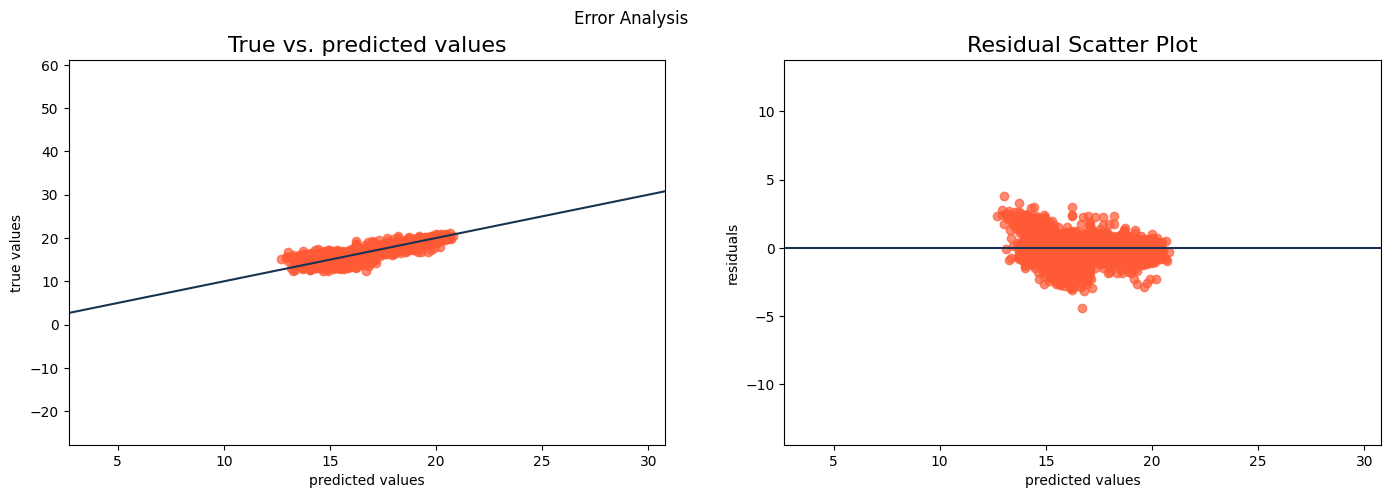

In [26]:
error_analysis(y_test,y_test_predicted)